In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import keras
from keras.preprocessing.image import ImageDataGenerator

visualize_data = True

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Summary of this notebook

1) [Data processing and visualization](#Datamanagement) 
<br>
2) [Building a simple baseline with a CNN and Keras](#Baseline)
<br>
3) [Improvements : Going deeper](#Improvements)
<br>
> a) [Making the model deeper in order to overfit and see the limit](#Overfit)
<br>
> b) [Augmentation, dropout](#Augmentation)
<br>
> c) [Using transfer learning](#TransferLearning)
<br>

4) [Making predictions on the test set](#Predictions)
<br>
5) [Going further](#WhatIf)

<a id='Datamanagement'></a>
# Data processing and visualization 


In [2]:
# Reading label file
labels = pd.read_table("label_train.txt", header = None)
nb_data = labels.shape[0] # nb_data = 111430

print(labels.iloc[:,0].value_counts()) # => 1 : 96179 and 0 : 15250

1    96180
0    15250
Name: 0, dtype: int64


The dataset is unbalanced, which means the best metric to be used is the area under the ROC curve.
However since the metric wasn't specified in the requirements, we will mainly use the accuracy.
In the improvement part we'll have a talk on using the ROC AUC and how to optimize this metric.

111430.0
--------------------------------------------------
Label : 0


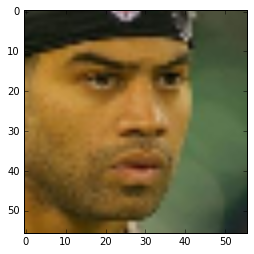

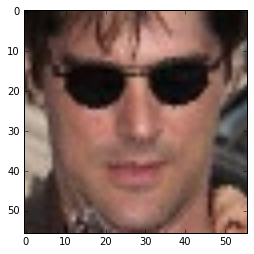

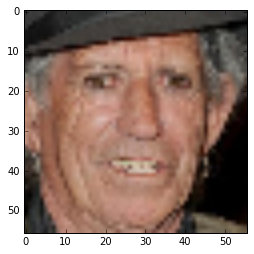

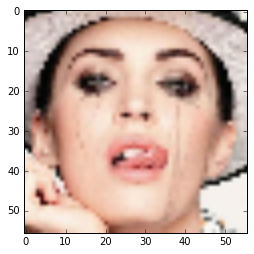

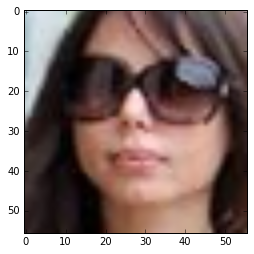

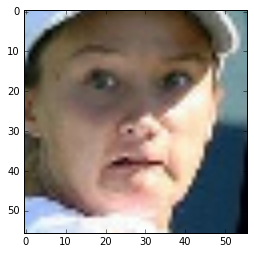

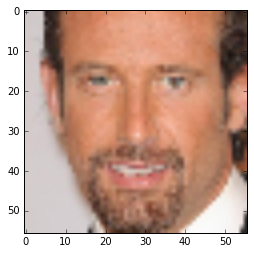

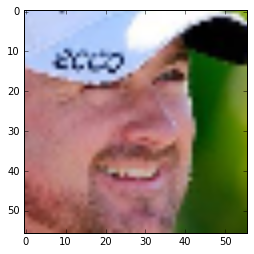

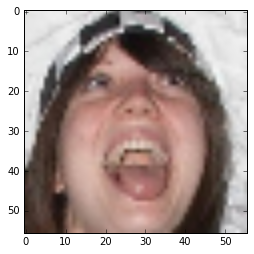

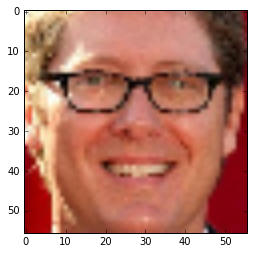

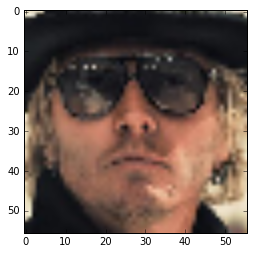

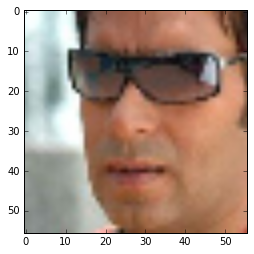

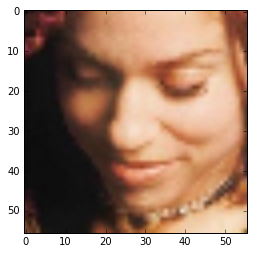

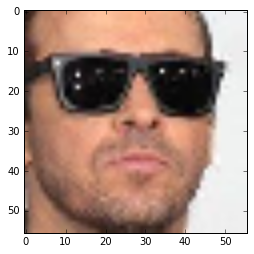

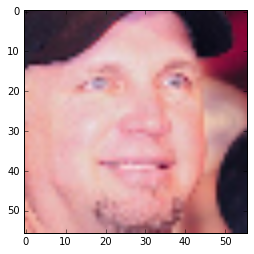

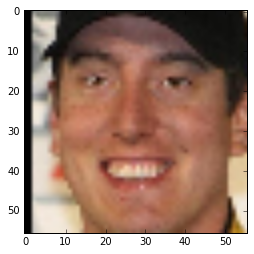

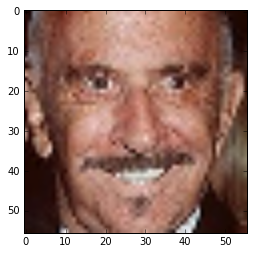

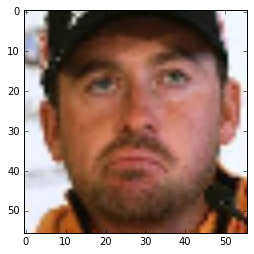

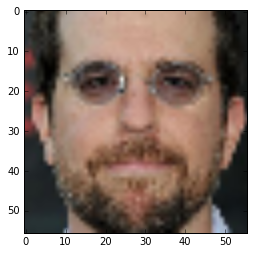

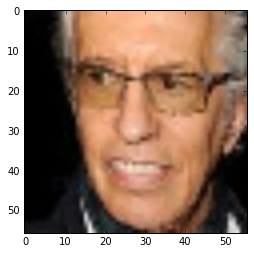

--------------------------------------------------
Label : 1


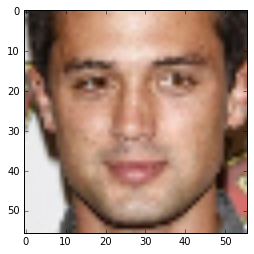

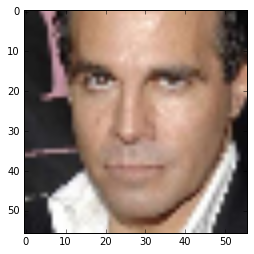

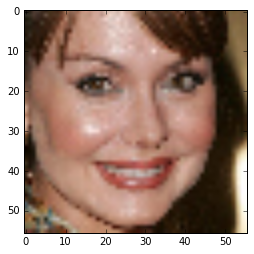

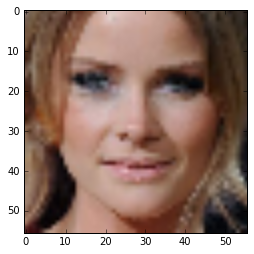

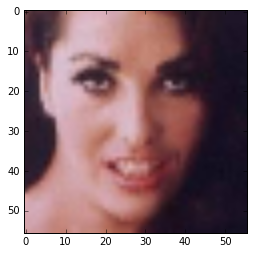

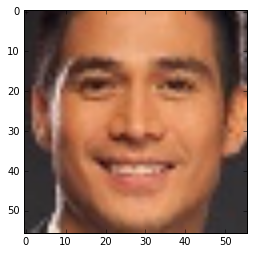

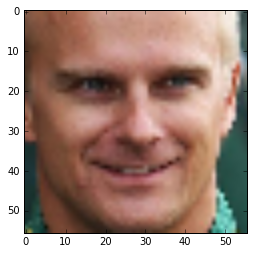

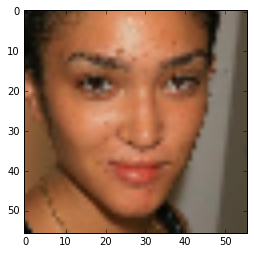

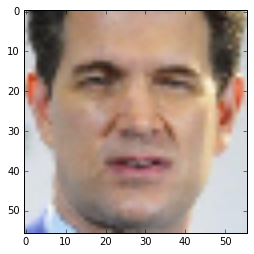

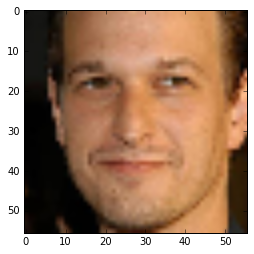

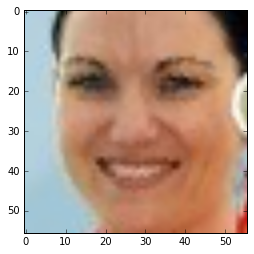

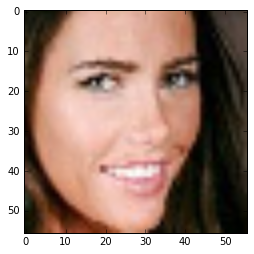

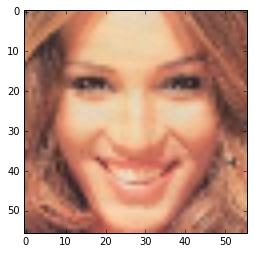

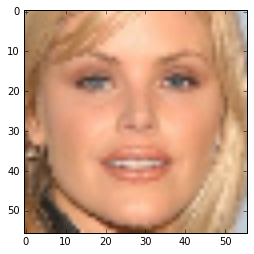

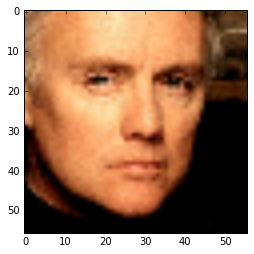

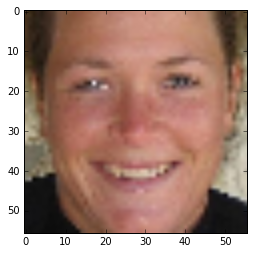

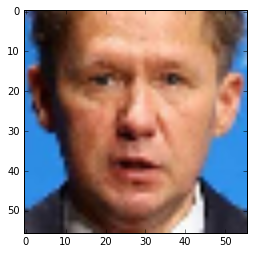

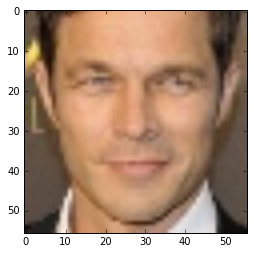

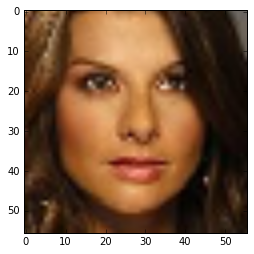

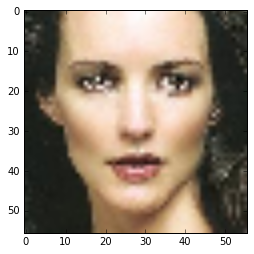

In [3]:
# Reading the train images file
train_filename = "db_train.raw"
train_file = np.fromfile(train_filename, dtype='uint8') # uint8 : [0,255]

# Sanity check of nb of images  
print(float(len(train_file))/(56.0*56.0*3.0))  # => 111430.0 = nb_data; OK


# Reshaping for easy image access
input_images = np.reshape(train_file,(-1,56,56,3))

# Visualizing the images with corresponding label to better understand the problem
if visualize_data :
    
    label_is_0 = labels[labels.values == 0].index
    label_is_1 = labels[labels.values == 1].index
    
    print("-"*50 + "\nLabel : 0")
    
    for i in label_is_0[:20] :
        plt.imshow(input_images[i])
        plt.show()
        
    print("-"*50 + "\nLabel : 1")

    for i in label_is_1[:20] :
        plt.imshow(input_images[i])
        plt.show()

From the visualization we get the idea that the label indicate if the face is clear.
If eyeglasses, a beard or a hat are present in the picture then we cannot clearly identify the person.
<br>
However I'm not sure at 100% since it is difficult for me to predict some cases. 
Let's see what a neural network can do !

In [4]:
# Organize the dataset

# normalize the data
input_images = input_images * 1.0/255.0 

# Shuffle data and get a train and a validation sets
X_train, X_val, y_train, y_val = train_test_split(input_images,
                                                  labels.values,
                                                  train_size = 0.85,
                                                  random_state = 42)

<a id='Baseline'></a>
# Building a simple baseline with a CNN and keras

Simple baseline, a classical ConvNet with :
> Convolutional layers
<br>
> Pooling layers
<br>
> Some dense layers
<br>
<br>
> The last activation is a sigmoid since it is a one label classification
<br>
> The activation function is the cross entropy 
<br>
> The optimizer is RMSprop but could be also Adam
<br>
> The accuracy is the metric here

In [5]:
baseline_model = keras.models.Sequential()
baseline_model.add(keras.layers.Conv2D(12, (3,3), activation = 'relu', input_shape = (56,56,3)))
baseline_model.add(keras.layers.MaxPool2D())
baseline_model.add(keras.layers.Conv2D(36, (3,3), activation = 'relu'))
baseline_model.add(keras.layers.MaxPool2D())
baseline_model.add(keras.layers.Conv2D(64, (3,3), activation = 'relu'))
baseline_model.add(keras.layers.MaxPool2D())
baseline_model.add(keras.layers.Conv2D(128, (3,3), activation = 'relu', name = "lastConvLayer"))

baseline_model.add(keras.layers.Flatten())
baseline_model.add(keras.layers.Dense(256, activation = 'relu'))
baseline_model.add(keras.layers.Dense(128, activation = 'relu'))
baseline_model.add(keras.layers.Dense(32, activation = 'relu'))
baseline_model.add(keras.layers.Dense(1, activation = 'sigmoid'))

baseline_model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.RMSprop(lr=1e-4), metrics = ["acc"])

baseline_model.summary() # nb of parameters : 431141

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 12)        336       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 36)        3924      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        20800     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
lastConvLayer (Conv2D)       (None, 3, 3, 128)         73856     
__________

In [6]:
# Training the model just for 5 epochs to get an idea

history = baseline_model.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_data = (X_val, y_val))

Train on 94715 samples, validate on 16715 samples
Epoch 1/5
94715/94715 [==============================] - 52s 554us/step - loss: 0.2439 - acc: 0.9117 - val_loss: 0.1801 - val_acc: 0.9335
Epoch 2/5
94715/94715 [==============================] - 45s 475us/step - loss: 0.1617 - acc: 0.9398 - val_loss: 0.1545 - val_acc: 0.9395
Epoch 3/5
94715/94715 [==============================] - 46s 481us/step - loss: 0.1425 - acc: 0.9453 - val_loss: 0.1408 - val_acc: 0.9466
Epoch 4/5
94715/94715 [==============================] - 45s 474us/step - loss: 0.1329 - acc: 0.9492 - val_loss: 0.1354 - val_acc: 0.9484
Epoch 5/5
94715/94715 [==============================] - 45s 477us/step - loss: 0.1256 - acc: 0.9518 - val_loss: 0.1267 - val_acc: 0.9523


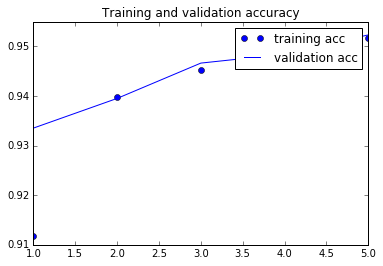

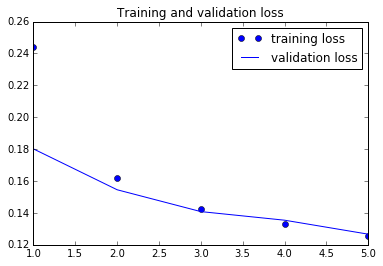

In [7]:
# Plotting the results 

# We define a custom function that will also be used after each learning
def plt_results(history) : 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'training acc')
    plt.plot(epochs, val_acc, 'b', label = 'validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label = 'training loss')
    plt.plot(epochs, val_loss, 'b', label = 'validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
plt_results(history)

95% is not so bad considering it's our baseline
<br>
Actually the percentage of 1 is 96179/111430 = 86,3% therefore if the accuracy is higher then the network is better than a dumb classifier. 
<br>
We can check his predictions on the validation set and see if it is as expected and what might be difficult for him to predict.

[0.99478614]


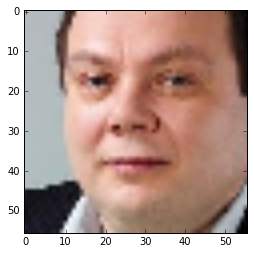

[0.9983986]


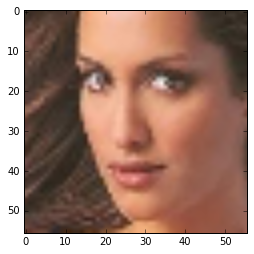

[0.9996086]


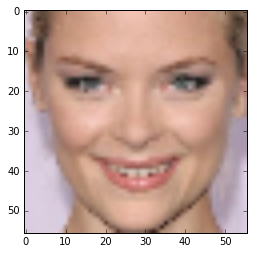

[0.9817213]


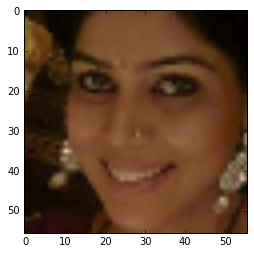

[0.9973755]


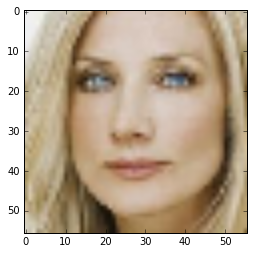

[9.858237e-07]


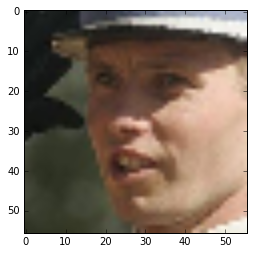

[0.9292582]


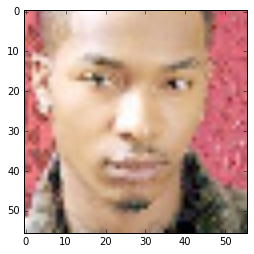

[0.98707366]


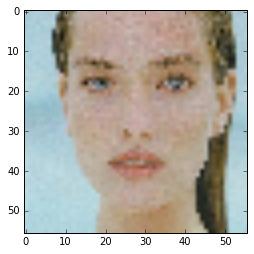

[0.93651843]


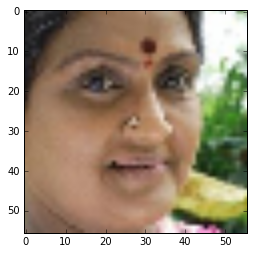

[0.01886195]


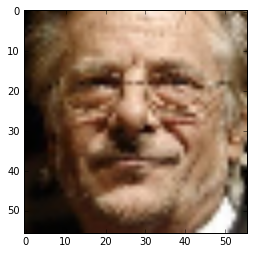

[0.9969548]


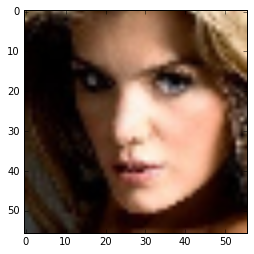

[0.94089663]


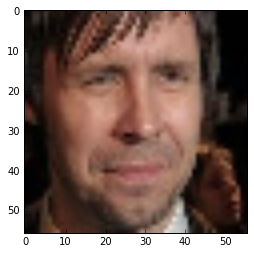

[0.9988921]


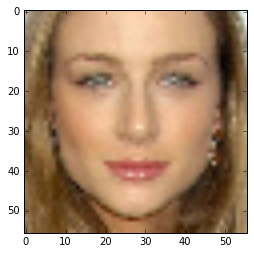

[0.99837565]


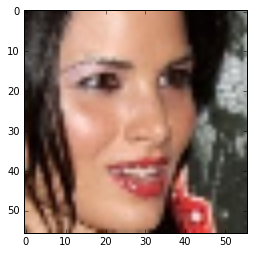

[0.98636824]


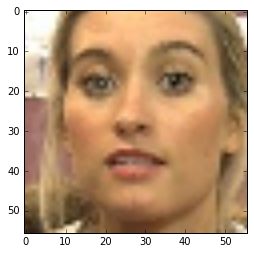

[0.97435683]


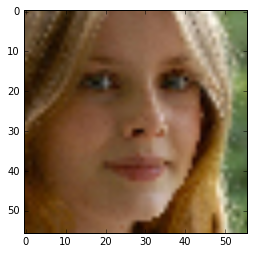

[0.9981048]


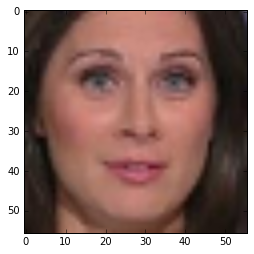

[0.99764377]


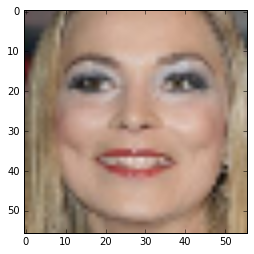

[0.9899858]


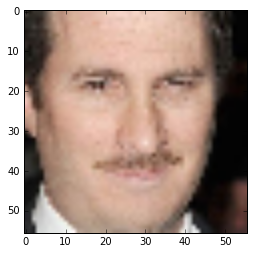

[9.551046e-08]


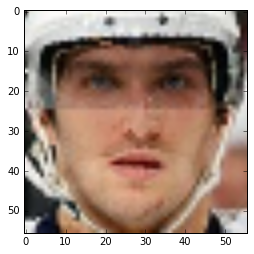

In [12]:
y_pred = baseline_model.predict(X_val)

for i in range(20) :
    plt.imshow(X_val[i])
    print(y_pred[i])
    plt.show()

<a id='Improvements'></a>
# 3) Improvements : Going deeper

So there is room for improvement :

> a) [Making the model deeper in order to overfit and see the limit](#Overfit)
<br>
> b) [Augmentation, dropout](#Augmentation)
<br>
> c) [Using transfer learning](#TransferLearning)

<a id='Overfit'></a>
## a) Making the model deeper in order to overfit and see the limit

In [40]:
deeper_model = keras.models.Sequential()
deeper_model.add(keras.layers.Conv2D(24, (3,3), activation = 'relu', padding = "same", input_shape = (56,56,3)))
deeper_model.add(keras.layers.MaxPool2D())
deeper_model.add(keras.layers.Conv2D(48, (3,3), activation = 'relu', padding = "same"))
deeper_model.add(keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = "same"))
deeper_model.add(keras.layers.MaxPool2D())
deeper_model.add(keras.layers.Conv2D(96, (3,3), activation = 'relu', padding = "same"))
deeper_model.add(keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = "same"))
deeper_model.add(keras.layers.MaxPool2D())
deeper_model.add(keras.layers.Conv2D(164, (3,3), activation = 'relu', padding = "same"))
deeper_model.add(keras.layers.Conv2D(256, (3,3), activation = 'relu', padding = "same"))
deeper_model.add(keras.layers.MaxPool2D())


deeper_model.add(keras.layers.Flatten())
deeper_model.add(keras.layers.Dense(256, activation = 'relu'))
deeper_model.add(keras.layers.Dense(128, activation = 'relu'))
deeper_model.add(keras.layers.Dense(64, activation = 'relu'))
deeper_model.add(keras.layers.Dense(32, activation = 'relu'))
deeper_model.add(keras.layers.Dense(1, activation = 'sigmoid'))

deeper_model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.RMSprop(lr=1e-4), metrics = ["acc"])

deeper_model.summary() # The number of parameters is now 3.5 times more than the baseline

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 56, 56, 24)        672       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 28, 24)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 48)        10416     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 64)        27712     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 128)       110720    
__________

In [14]:
# Training the model just for 5 epochs to get an idea

history = deeper_model.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_data = (X_val, y_val))

Train on 94715 samples, validate on 16715 samples
Epoch 1/5
94715/94715 [==============================] - 125s 1ms/step - loss: 0.2254 - acc: 0.9204 - val_loss: 0.1528 - val_acc: 0.9434
Epoch 2/5
94715/94715 [==============================] - 132s 1ms/step - loss: 0.1429 - acc: 0.9458 - val_loss: 0.1269 - val_acc: 0.9498
Epoch 3/5
94715/94715 [==============================] - 132s 1ms/step - loss: 0.1259 - acc: 0.9518 - val_loss: 0.1223 - val_acc: 0.9518
Epoch 4/5
94715/94715 [==============================] - 132s 1ms/step - loss: 0.1190 - acc: 0.9544 - val_loss: 0.1241 - val_acc: 0.9547
Epoch 5/5
94715/94715 [==============================] - 132s 1ms/step - loss: 0.1160 - acc: 0.9560 - val_loss: 0.1176 - val_acc: 0.9538


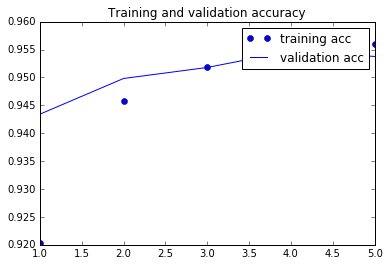

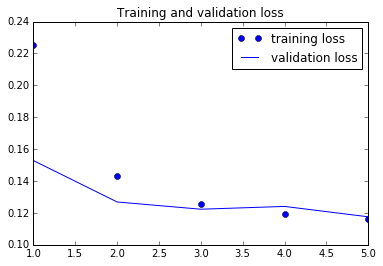

In [15]:
# Plotting the results 

plt_results(history)

In [17]:
# Before going further we clearly see that it's difficult to overfit and that we can get stuck on a plateau
# So we will keep the same model but change the learning each time we are on a plateau

# Using keras callback we divide by 2 the learning rate each time the loss has stopped improving
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, verbose=1, min_lr=1e-7)

# AN this time we train for 20 epochs
history = deeper_model.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data = (X_val, y_val),callbacks = [reduceLR])

Train on 94715 samples, validate on 16715 samples
Epoch 1/20
94715/94715 [==============================] - 131s 1ms/step - loss: 0.2106 - acc: 0.9245 - val_loss: 0.1474 - val_acc: 0.9420
Epoch 2/20
94715/94715 [==============================] - 133s 1ms/step - loss: 0.1352 - acc: 0.9478 - val_loss: 0.1240 - val_acc: 0.9504
Epoch 3/20
94715/94715 [==============================] - 139s 1ms/step - loss: 0.1210 - acc: 0.9532 - val_loss: 0.1221 - val_acc: 0.9520
Epoch 4/20
94715/94715 [==============================] - 142s 1ms/step - loss: 0.1136 - acc: 0.9559 - val_loss: 0.1244 - val_acc: 0.9527
Epoch 5/20
94715/94715 [==============================] - 144s 2ms/step - loss: 0.1110 - acc: 0.9574 - val_loss: 0.1280 - val_acc: 0.9535
Epoch 6/20
94715/94715 [==============================] - 145s 2ms/step - loss: 0.1102 - acc: 0.9579 - val_loss: 0.1125 - val_acc: 0.9554
Epoch 7/20
94715/94715 [==============================] - 148s 2ms/step - loss: 0.1091 - acc: 0.9582 - val_loss: 0.1173 - 

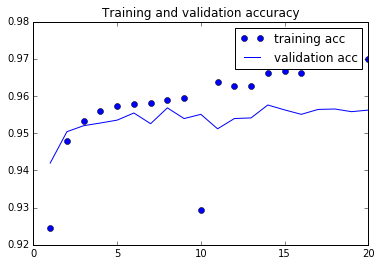

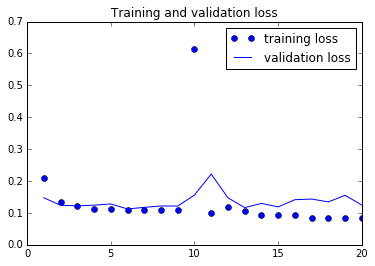

In [18]:
# Plotting the results 

plt_results(history)

Yes our model is finally overfitting ! Let's add Augmentation now and then we will try dropout if necessary 

<a id='Augmentation'></a>
## b) Augmentation, dropout

We will use Keras ImageDataGenerator.
<br>
To see how it works we can visualize for an image which kind of augmentation we can do and what can be interesting

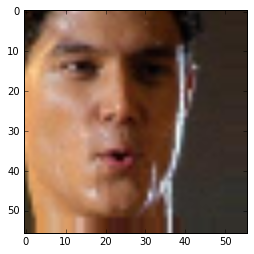

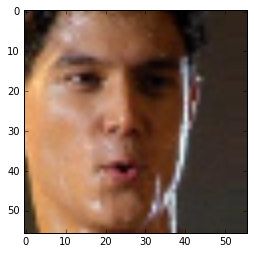

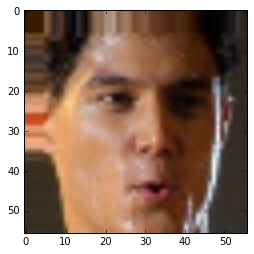

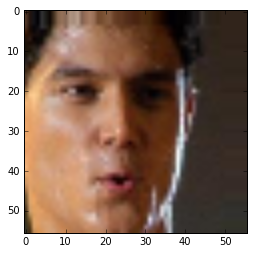

In [36]:
train_Gen = ImageDataGenerator(width_shift_range=0.1,
                               height_shift_range=0.1,
                              fill_mode = "nearest")

x = X_train[0].reshape((1,) + X_train[0].shape)

i = 0
for batch in train_Gen.flow(x, batch_size=1) : 
    plt.figure(i)
    imgplot = plt.imshow(batch[0])
    i+=1
    if i % 4 == 0 : 
        break

plt.show() 

It doesn't seem good, the way the interpolation is made on the corner when shifting may not increase the performances.
<br>
We can try visualize another way of filling : "reflect". 

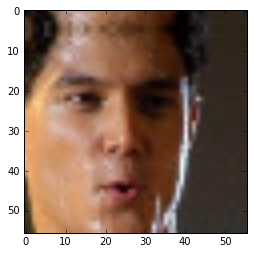

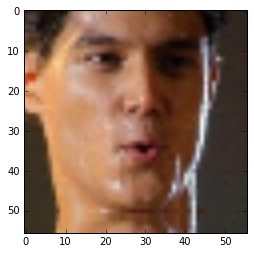

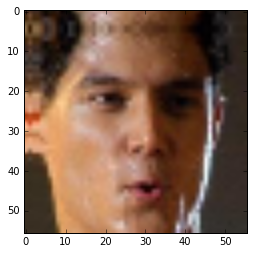

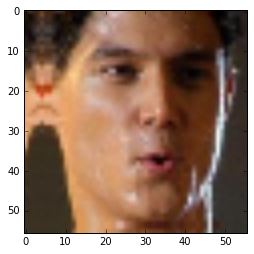

In [37]:
train_Gen = ImageDataGenerator(width_shift_range=0.1,
                               height_shift_range=0.1,
                              fill_mode = "reflect")

x = X_train[0].reshape((1,) + X_train[0].shape)

i = 0
for batch in train_Gen.flow(x, batch_size=1) : 
    plt.figure(i)
    imgplot = plt.imshow(batch[0])
    i+=1
    if i % 4 == 0 : 
        break

plt.show() 

In [23]:
# To check if this augmentation can improve the accuracy of the validation set we try a training

train_Gen = ImageDataGenerator(width_shift_range=0.1,
                               height_shift_range=0.1)#, horizontal_flip = True, rotation_range = 20, fill_mode='nearest')

reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, verbose=1, min_lr=1e-7)
history = deeper_model.fit_generator(train_Gen.flow(X_train, y_train, batch_size = 32), epochs = 20, validation_data = (X_val, y_val),callbacks = [reduceLR])

Epoch 1/20
2960/2960 [==============================] - 130s 44ms/step - loss: 0.2384 - acc: 0.9188 - val_loss: 0.1689 - val_acc: 0.9385
Epoch 2/20
2960/2960 [==============================] - 144s 49ms/step - loss: 0.1547 - acc: 0.9422 - val_loss: 0.1450 - val_acc: 0.9419
Epoch 3/20
2960/2960 [==============================] - 194s 65ms/step - loss: 0.1378 - acc: 0.9472 - val_loss: 0.1321 - val_acc: 0.9484
Epoch 4/20
2960/2960 [==============================] - 246s 83ms/step - loss: 0.1313 - acc: 0.9493 - val_loss: 0.1223 - val_acc: 0.9512
Epoch 5/20
2960/2960 [==============================] - 277s 94ms/step - loss: 0.1302 - acc: 0.9505 - val_loss: 0.1243 - val_acc: 0.9499
Epoch 6/20
2960/2960 [==============================] - 291s 98ms/step - loss: 0.1299 - acc: 0.9510 - val_loss: 0.1177 - val_acc: 0.9535
Epoch 7/20
2960/2960 [==============================] - 300s 101ms/step - loss: 0.1337 - acc: 0.9502 - val_loss: 0.1580 - val_acc: 0.9527
Epoch 8/20
2959/2960 [==================

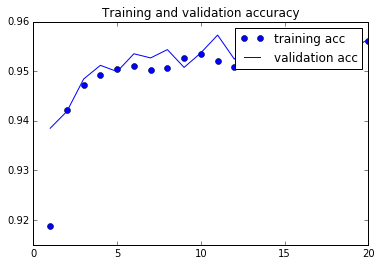

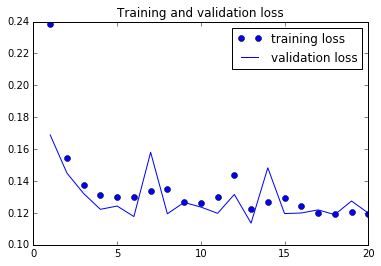

In [24]:
# Plotting the results 

plt_results(history)

We see that the final validation set's accuracy is just a bit higher, so if we use shifting we should use
it carefully.
<br>
Now let's try augmentation without using any augmentation that need filling. Let's flip images for example.

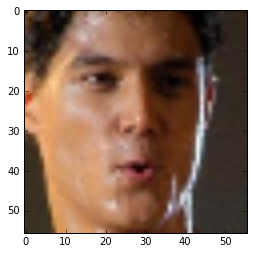

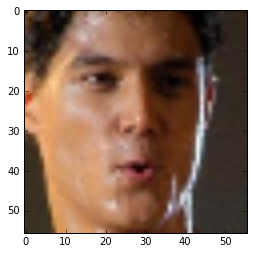

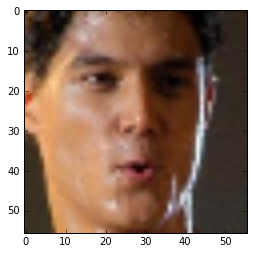

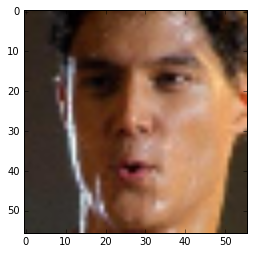

In [39]:
train_Gen = ImageDataGenerator(horizontal_flip = True)

x = X_train[0].reshape((1,) + X_train[0].shape)

i = 0
for batch in train_Gen.flow(x, batch_size=1) : 
    plt.figure(i)
    imgplot = plt.imshow(batch[0])
    i+=1
    if i % 4 == 0 : 
        break

plt.show() 

In [41]:
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, verbose=1, min_lr=1e-7)
history = deeper_model.fit_generator(train_Gen.flow(X_train, y_train, batch_size = 32), epochs = 20, validation_data = (X_val, y_val),callbacks = [reduceLR])

Epoch 1/20
2960/2960 [==============================] - 129s 44ms/step - loss: 0.2059 - acc: 0.9265 - val_loss: 0.1505 - val_acc: 0.9439
Epoch 2/20
2960/2960 [==============================] - 130s 44ms/step - loss: 0.1400 - acc: 0.9472 - val_loss: 0.1278 - val_acc: 0.9512
Epoch 3/20
2960/2960 [==============================] - 139s 47ms/step - loss: 0.1281 - acc: 0.9509 - val_loss: 0.1197 - val_acc: 0.9553
Epoch 4/20
2960/2960 [==============================] - 150s 51ms/step - loss: 0.1238 - acc: 0.9530 - val_loss: 0.1218 - val_acc: 0.9530
Epoch 5/20
2960/2960 [==============================] - 165s 56ms/step - loss: 0.1249 - acc: 0.9533 - val_loss: 0.1399 - val_acc: 0.9484
Epoch 6/20
2960/2960 [==============================] - 176s 59ms/step - loss: 0.1223 - acc: 0.9536 - val_loss: 0.1230 - val_acc: 0.9558
Epoch 7/20
2960/2960 [==============================] - 186s 63ms/step - loss: 0.1245 - acc: 0.9537 - val_loss: 0.1192 - val_acc: 0.9538
Epoch 8/20
2959/2960 [===================

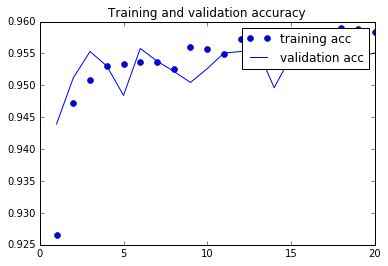

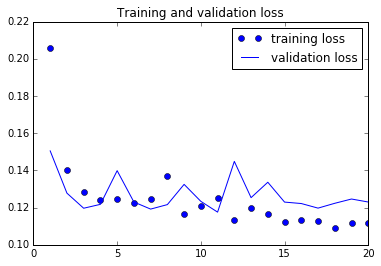

In [42]:
# Plotting the results 

plt_results(history)

# We save the model to make predictions after

deeper_model.save("deeper_learning_model.h5")

We can also try using dropout without augmentation.
<br>
In the following model we changed a few parameters after trying and testing even though a cross validation would
be highly recommended.
<br>
The activation function is not relu anymore but elu.
<br>
The optimizer is Adam, it converges faster than RMSProp.
<br>
Dropout has been added after each dense layer. 

In [7]:
deeper_model_dropout = keras.models.Sequential()
deeper_model_dropout.add(keras.layers.Conv2D(24, (3,3), activation = 'elu', padding = "same", input_shape = (56,56,3)))
deeper_model_dropout.add(keras.layers.MaxPool2D())
deeper_model_dropout.add(keras.layers.Conv2D(48, (3,3), activation = 'elu', padding = "same"))
deeper_model_dropout.add(keras.layers.Conv2D(64, (3,3), activation = 'elu', padding = "same"))
deeper_model_dropout.add(keras.layers.MaxPool2D())
deeper_model_dropout.add(keras.layers.Conv2D(96, (3,3), activation = 'elu', padding = "same"))
deeper_model_dropout.add(keras.layers.Conv2D(128, (3,3), activation = 'elu', padding = "same"))
deeper_model_dropout.add(keras.layers.MaxPool2D())
deeper_model_dropout.add(keras.layers.Conv2D(164, (3,3), activation = 'elu', padding = "same"))
deeper_model_dropout.add(keras.layers.Conv2D(256, (3,3), activation = 'elu', padding = "same"))
deeper_model_dropout.add(keras.layers.MaxPool2D())


deeper_model_dropout.add(keras.layers.Flatten())
deeper_model_dropout.add(keras.layers.Dense(256, activation = 'elu'))
deeper_model_dropout.add(keras.layers.Dropout(0.6)) # Higher dropout since the number of params here is 590 080
deeper_model_dropout.add(keras.layers.Dense(128, activation = 'elu'))
deeper_model_dropout.add(keras.layers.Dropout(0.4))
deeper_model_dropout.add(keras.layers.Dense(64, activation = 'elu'))
deeper_model_dropout.add(keras.layers.Dropout(0.3))
deeper_model_dropout.add(keras.layers.Dense(32, activation = 'elu'))
deeper_model_dropout.add(keras.layers.Dropout(0.2))
deeper_model_dropout.add(keras.layers.Dense(1, activation = 'sigmoid'))

# This time we choose Adam optimizer. We will see that we converge faster
deeper_model_dropout.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(lr=1e-4), metrics = ["acc"])

deeper_model_dropout.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 56, 56, 24)        672       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 24)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 48)        10416     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        27712     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 128)       110720    
__________

In [ ]:
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, verbose=1, min_lr=1e-7)

# The number of epochs has been reduced to 10 since it takes more time now
history = deeper_model_dropout.fit(X_train,
                                   y_train,
                                   batch_size = 32,
                                   epochs = 10,   
                                   validation_data = (X_val, y_val),
                                   callbacks = [reduceLR])

Train on 94715 samples, validate on 16715 samples
Epoch 1/10
94715/94715 [==============================] - 263s 3ms/step - loss: 0.2043 - acc: 0.9280 - val_loss: 0.1408 - val_acc: 0.9463
Epoch 2/10
94715/94715 [==============================] - 296s 3ms/step - loss: 0.1403 - acc: 0.9470 - val_loss: 0.1241 - val_acc: 0.9516
Epoch 3/10
94715/94715 [==============================] - 305s 3ms/step - loss: 0.1249 - acc: 0.9524 - val_loss: 0.1224 - val_acc: 0.9538
Epoch 4/10
94715/94715 [==============================] - 304s 3ms/step - loss: 0.1108 - acc: 0.9566 - val_loss: 0.1156 - val_acc: 0.9552
Epoch 5/10
94715/94715 [==============================] - 305s 3ms/step - loss: 0.0957 - acc: 0.9625 - val_loss: 0.1315 - val_acc: 0.9531
Epoch 6/10
94715/94715 [==============================] - 311s 3ms/step - loss: 0.0812 - acc: 0.9682 - val_loss: 0.1229 - val_acc: 0.9558
Epoch 7/10
94715/94715 [==============================] - 309s 3ms/step - loss: 0.0667 - acc: 0.9739 - val_loss: 0.1462 - 

With dropout only we can see that we are still overfitting and severly. train acc : 0.9878 and val acc : 0.9531.
<br>
However instead of increasing the dropout parameters we can combine both techniques of regularization : Augmentation + dropout.
<br>
We also keep the model with Adam and elu activation function.

In [8]:
# We keep only the horizontal flip augmentation to make it simple
train_Gen = ImageDataGenerator(horizontal_flip = True)

# We add another callback : a checkpoint to save the best model, the one with the highest validation accuracy
checkpointer = keras.callbacks.ModelCheckpoint(filepath="deeper_dropout_Augmentation_learning_model.hdf5",
                                               save_best_only = True,
                                               monitor = "val_acc")

# We keep the reduce learning rate callback 
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, verbose=1, min_lr=1e-7)

# And we had another callback to simply stop the training when the validation accuracy doesn't increase anymore
# So we avoid spending too much time on each training 
earlyStopping = keras.callbacks.EarlyStopping('val_acc', patience=3, mode="max")

history = deeper_model_dropout.fit_generator(train_Gen.flow(X_train, y_train, batch_size = 32),
                                             epochs = 10,
                                             validation_data = (X_val, y_val),
                                             callbacks = [reduceLR,checkpointer,earlyStopping])

Epoch 1/10
2960/2960 [==============================] - 206s 70ms/step - loss: 0.2068 - acc: 0.9267 - val_loss: 0.1393 - val_acc: 0.9478
Epoch 2/10
2960/2960 [==============================] - 280s 95ms/step - loss: 0.1429 - acc: 0.9464 - val_loss: 0.1308 - val_acc: 0.9484
Epoch 3/10
2960/2960 [==============================] - 294s 99ms/step - loss: 0.1296 - acc: 0.9506 - val_loss: 0.1255 - val_acc: 0.9502
Epoch 4/10
2960/2960 [==============================] - 295s 100ms/step - loss: 0.1202 - acc: 0.9533 - val_loss: 0.1294 - val_acc: 0.9491
Epoch 5/10
2960/2960 [==============================] - 295s 100ms/step - loss: 0.1116 - acc: 0.9570 - val_loss: 0.1169 - val_acc: 0.9542
Epoch 6/10
2960/2960 [==============================] - 296s 100ms/step - loss: 0.1047 - acc: 0.9592 - val_loss: 0.1169 - val_acc: 0.9564
Epoch 7/10
2960/2960 [==============================] - 296s 100ms/step - loss: 0.0981 - acc: 0.9607 - val_loss: 0.1191 - val_acc: 0.9543
Epoch 8/10
2960/2960 [===============

<a id='Augmentation'></a>
## c) Trying transfer learning 

In [64]:
from keras.applications import VGG16

# We use the weights of ImageNet, oftenly used when doing transfer learning
conv_base = VGG16(weights = "imagenet",
                  include_top = False,
                  input_shape = (56,56,3))


transfer_model = keras.models.Sequential()
transfer_model.add(conv_base)
transfer_model.add(keras.layers.Flatten())
transfer_model.add(keras.layers.Dense(256, activation='relu'))
transfer_model.add(keras.layers.Dense(64, activation='relu'))
transfer_model.add(keras.layers.Dense(1, activation='sigmoid'))


# We freeze the first 4 block of the VGG network but set the whole block 5 as trainable
# We fine tune this art of the network
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers : 
    if layer.name == 'block5_conv1' : 
        set_trainable = True
    if set_trainable : 
        layer.trainable = True
    else : 
        layer.trainable = False


transfer_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(lr=1e-4), metrics=['acc'])
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_68 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 65        
Total params: 14,862,529
Trainable params: 7,227,265
Non-trainable params: 7,635,264
_________________________________________________________________


In [65]:
train_Gen = ImageDataGenerator(width_shift_range=0.1,
                               height_shift_range=0.1)

reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, verbose=1, min_lr=1e-8)

# As before we use early stopping but with a higher patience
earlyStopping = keras.callbacks.EarlyStopping('val_acc', patience=10, mode="max")

history = transfer_model.fit_generator(train_Gen.flow(X_train, y_train, batch_size = 32),
                              epochs = 80,
                              validation_data = (X_val, y_val),
                              callbacks = [reduceLR,earlyStopping])

Epoch 1/80
2960/2960 [==============================] - 636s 215ms/step - loss: 0.1988 - acc: 0.9309 - val_loss: 0.1571 - val_acc: 0.9418
Epoch 2/80
2960/2960 [==============================] - 710s 240ms/step - loss: 0.1775 - acc: 0.9403 - val_loss: 0.1525 - val_acc: 0.9463
Epoch 3/80
2960/2960 [==============================] - 700s 237ms/step - loss: 0.1714 - acc: 0.9429 - val_loss: 0.1682 - val_acc: 0.9464
Epoch 4/80
2960/2960 [==============================] - 701s 237ms/step - loss: 0.1690 - acc: 0.9457 - val_loss: 0.1613 - val_acc: 0.9468
Epoch 5/80
2960/2960 [==============================] - 697s 236ms/step - loss: 0.1731 - acc: 0.9458 - val_loss: 0.1818 - val_acc: 0.9460
Epoch 6/80
2959/2960 [============================>.] - ETA: 0s - loss: 0.1753 - acc: 0.9468
Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.99999987369e-05.
2960/2960 [==============================] - 697s 236ms/step - loss: 0.1753 - acc: 0.9467 - val_loss: 0.1908 - val_acc: 0.9404
Epoch 7/80
296

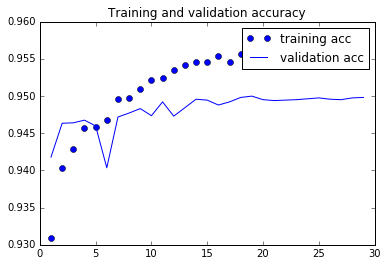

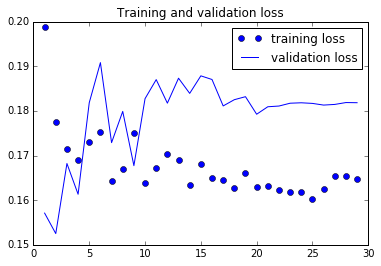

In [67]:
# Plotting the results 

plt_results(history)

# We save the model for predictions step after

transfer_model.save("transfer_learning_model.h5")

It is not so good considering the results we had without a pretrained network

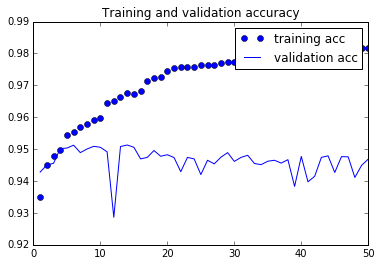

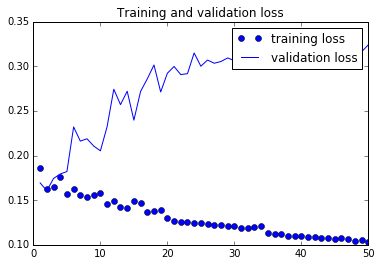

In [26]:
# Those are old results that I got with the model above without augmentation 

plt_results(history)

It shows that we can do better, we have to focus on regularization but using cross validation to better validate
each parameter and access each layer in order to add dropout
<br>
Nevertheless a bunch of tests have been made on a dedicated server (paperspace): 
<br>
> Learning from block 5 conv 1 : around 7 million parameters : it's a lot so it's difficult to regularize properly
<br>
> Learning from block 5 conv 2 : around 5 million parameters
<br>
> Learning from block 5 conv 3 : around 2 million parameters but still difficult to train
<br>

The less convolutional layers we can train the more difficult is to find the match with frozen layers.

For information, we cannot use for example Resnet50 or InceptionV3 as pretrained models because those
are very deep CNN hence the input image size (56,56,3) is too small.
<br>
However we could use FaceNet : https://github.com/davidsandberg/facenet.
This is based on VGG model but trained on faces it should therefore have better results.

<a id='Prediction'></a>
## 4) Making prediction on the test set

In [24]:
# Reading the test images file
test_filename = "db_val.raw"
test_file = np.fromfile(test_filename, dtype='uint8') # uint8 : [0,255]

# Reshaping for easy image access
test_images = np.reshape(test_file,(-1,56,56,3))


# Normalizing the images
test_images = test_images * 1.0/255.0

In [25]:
# Predictions of the VGG model
# Loading the model

model = keras.models.load_model('deeper_dropout_Augmentation_learning_model.hdf5')
predictions = model.predict(test_images)

[0.99974626]


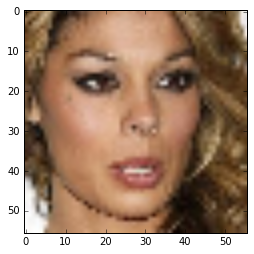

[0.9983181]


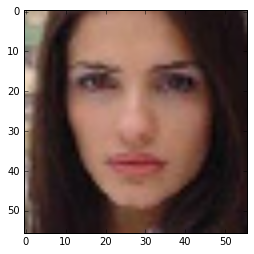

[0.9998134]


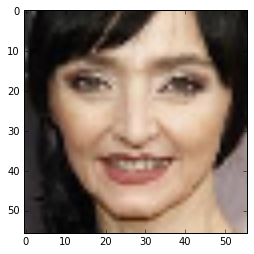

[0.99921]


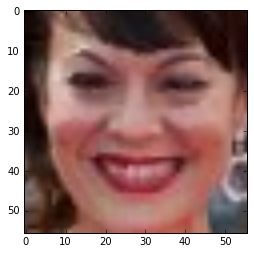

[0.9972926]


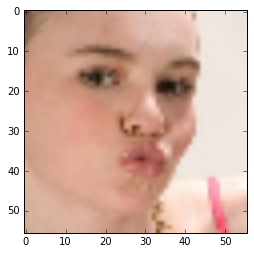

[0.9995454]


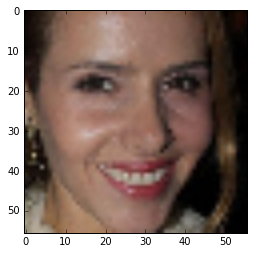

[0.99988174]


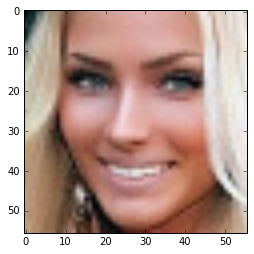

[0.99046445]


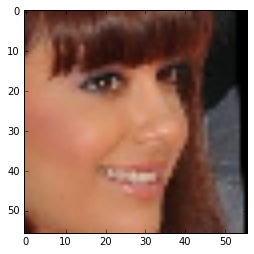

[0.01435438]


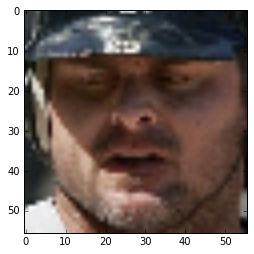

[0.99985147]


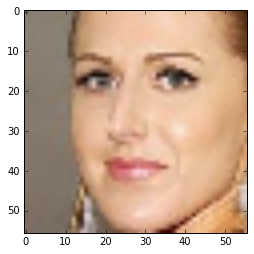

[0.25268215]


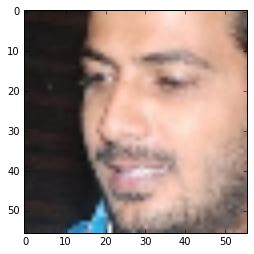

[0.7735266]


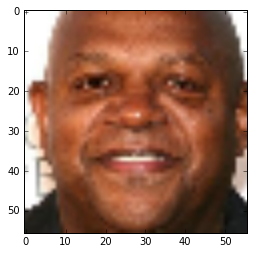

[0.99959856]


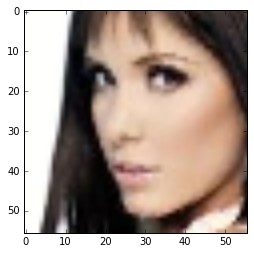

[1.8826217e-05]


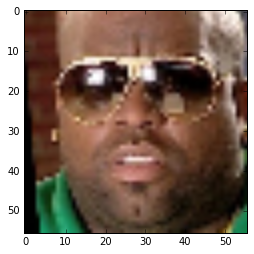

[0.9874741]


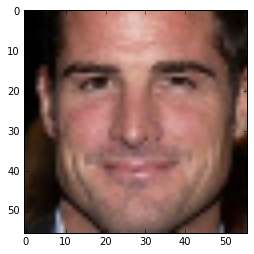

[0.9003962]


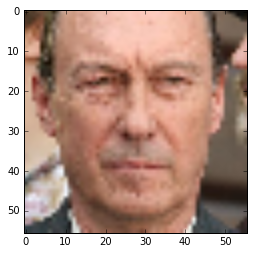

[0.9997216]


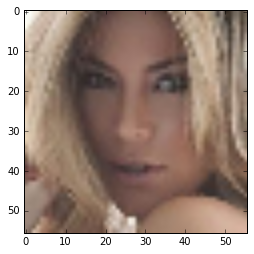

[0.9579076]


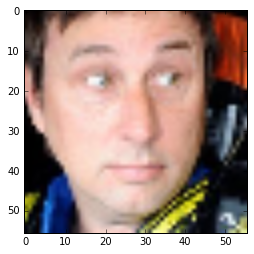

[0.01254306]


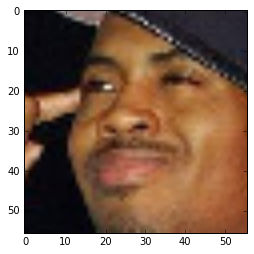

[0.98419005]


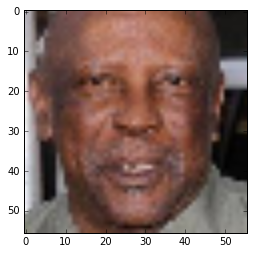

In [26]:
# Checking that the labels seem ok
for i, pred in enumerate(predictions[:20]) : 
    print(pred)
    plt.imshow(test_images[i])
    plt.show()
    
# Saving to a file the predictions
with open("label_val.txt",'w') as validation_file :
    for pred in predictions : 
        validation_file.write(str(pred[0]) + "\n")

<a id='WhatIf'></a>
## 5) Going further

There are plenty of other things to explore ! Since the GPU card used for this notebook is a 750ti 2GB, 
the training time was quite long. However with more GPU power and time, we can go further :
<br>
> Do cross validation for each training to validate augmentation method, dropout, nb of layers, etc.
<br>
> Explore maximizing the metric ROC AUC 
<br>
> Look at activations to have information about what is important for the network.
<br>
> Do some research about the subject like eyeglasses detection and implement new architectures/algorithms
<br>
> Have a hold out set to do proper blending with several models (however this is not relevant for real time cases)

<a id='More'></a>
## 6) A bit more : simple machine learning model

It is a little bit off topic but it can be interesting to see how 
a machine learning model like Random forest perfom on this task.

In [4]:
# Organize the dataset

from sklearn.model_selection import train_test_split

X_train_ML, X_val_ML, y_train_ML, y_val_ML = train_test_split(input_images,labels.values, train_size = 0.9)

from sklearn.ensemble import RandomForestClassifier

# For this classifier we reshape the inputs in one vector per image
X_train_ML = np.reshape(X_train_ML, (-1,56*56*3)) 
X_val_ML = np.reshape(X_val_ML, (-1,56*56*3))

# We use only 20 etimators but more can be used for better results in theory
clf = RandomForestClassifier(n_estimators = 20, n_jobs = -1)
clf.fit(X_train_ML, y_train_ML)

# We predict on the validation set
from sklearn.metrics import accuracy_score

y_pred_ML = clf.predict(X_val_ML)
print(accuracy_score(y_val_ML, y_pred_ML)) # => almost 92 % 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


0.9183343803284574
